#### This script is for converting one audio into a numpy array and json dictionary
Author: Matthias Bittner

e-mail: matthias.bittner1@gmx.at

Features are read from a  csv and then used for training

In [ ]:
from pyAudioAnalysis import MidTermFeatures as mF 
from pyAudioAnalysis import ShortTermFeatures as sF 
from pyAudioAnalysis import audioBasicIO
import matplotlib.pyplot as plt
import numpy as np

#### Read one Audio File from folder

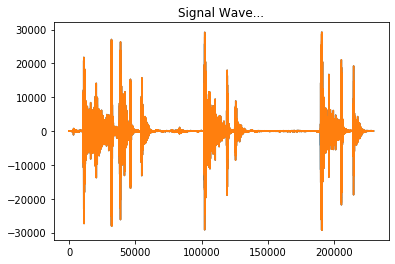

In [161]:
#[sampling_rate, signal] = audioBasicIO.read_audio_file("./data_c_s/Coughing/cough - 2.wav") #cool looking cough
#[sampling_rate, signal] = audioBasicIO.read_audio_file("./data_c_s/Coughing/58792__syna-max__cough.wav")
[sampling_rate, signal] = audioBasicIO.read_audio_file("./data_c_s/Coughing/371360__goldkelchen__cough.wav")
#[sampling_rate, signal] = audioBasicIO.read_audio_file("./data_c_s/Sneezing/144692__tekgnosis__sneeze.wav")
plt.figure
plt.title("Signal Wave...")
plt.plot(signal)
plt.show()

##### Create feature vector  from signal


In [162]:
mid_window = round(0.1 * sampling_rate)
mid_step =  round(0.1 * sampling_rate)                                   
short_window =  round(sampling_rate * 0.01)
short_step = round(sampling_rate * 0.01)
       
signal = audioBasicIO.stereo_to_mono(signal)
print(type(signal))
print(np.shape(signal))
signal = signal.astype('float64') # this line is because librosa was making an error - need floats

[mid_features, short_features, mid_feature_names] = mF.mid_feature_extraction(signal, sampling_rate, mid_window, mid_step, short_window, short_step);
mid_features = np.transpose(mid_features)
mid_term_features = mid_features.mean(axis=0)
print(np.shape(mid_term_features))
len(mid_feature_names)


<class 'numpy.ndarray'>
(229888,)
(136,)


136

##### Create Spektrogram  from Audio Signal

(128, 450)


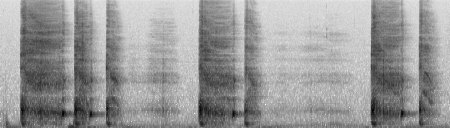

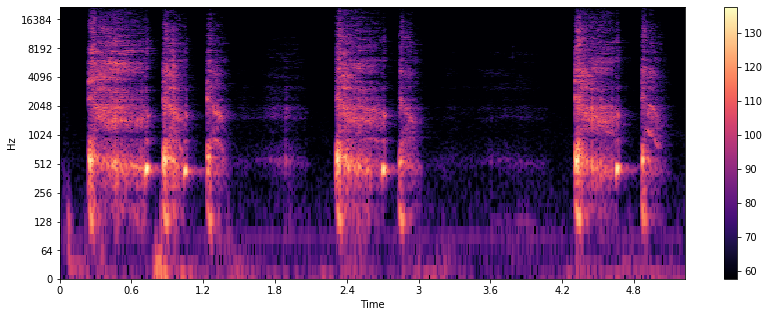

In [164]:
#specgram, TimeAxis, FreqAxis = sF.spectrogram(signal, sampling_rate, round(sampling_rate * 0.01),round(sampling_rate * 0.01), True)
#chromagram, chroma_TimeAxis, chroma_FreqAxis = sF.chromagram(signal, sampling_rate, round(sampling_rate * 0.01), round(sampling_rate * 0.01), True)

import librosa
import librosa.display
import skimage

X = librosa.stft(signal)
Xdb = librosa.amplitude_to_db(abs(X))
#plt.figure(figsize=(14, 5))
#librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
#plt.colorbar()

fig = plt.figure(figsize=(14, 5))
spec = librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

#fig.savefig('spec.png')

hop_length = 512 # number of samples per time-step in spectrogram
n_mels = 128 # number of bins in spectrogram. Height of image
time_steps = 384 # number of time-steps. Width of image

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr,  hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    return img
    # save as PNG
    #plt.imshow(img)

img = spectrogram_image(signal, sr=sampling_rate, hop_length=hop_length, n_mels=n_mels)
print(np.shape(img))
from PIL import Image
pil_img = Image.fromarray(img)
im.save("your_file1.jpeg")
display(pil_img)

##### Create JSON Dictionarry with features

In [166]:
import json
mid_term_features_list = mid_term_features.tolist( )
label = 1
feature_dict = dict(zip(['label'] + mid_feature_names, [label] + mid_term_features_list))
print(type(feature_dict))
feature_dict_json = json.dumps(feature_dict)
print(type(feature_dict_json))
print(feature_dict_json)

<class 'dict'>
<class 'str'>
{"label": 1, "zcr_mean": 0.0628859348198971, "energy_mean": 0.007310721447093463, "energy_entropy_mean": 2.978152999914349, "spectral_centroid_mean": 0.17317829963911374, "spectral_spread_mean": 0.21981411633888917, "spectral_entropy_mean": 0.4843918152898911, "spectral_flux_mean": 0.026977192046766803, "spectral_rolloff_mean": 0.08121783876500858, "mfcc_1_mean": -36.2820905188605, "mfcc_2_mean": -1.366011546874826, "mfcc_3_mean": -1.3505490081585312, "mfcc_4_mean": 0.1479370442768879, "mfcc_5_mean": 0.30898899494022275, "mfcc_6_mean": 1.0939306253238352, "mfcc_7_mean": 0.5072840824099276, "mfcc_8_mean": 0.06454975435041392, "mfcc_9_mean": 0.06319029271195523, "mfcc_10_mean": -0.023814897999964686, "mfcc_11_mean": 0.5421535730338122, "mfcc_12_mean": 0.7220186468626073, "mfcc_13_mean": 0.5133003929099679, "chroma_1_mean": 0.005634143091318145, "chroma_2_mean": 0.0027504237590680173, "chroma_3_mean": 0.01658034242195491, "chroma_4_mean": 0.002578443242987311,

###### Getting numpy arrays from JSON string


In [167]:
y_dict = json.loads(feature_dict_json)
(feature_names,values) = zip(*y_dict.items())
values = np.array(values) 
print(type(values))

<class 'numpy.ndarray'>


##### Create JSON Dictionary from spectrogram image